In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from target_encoding import TargetEncoderClassifier, TargetEncoder
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import json
from functools import partial
from dsb2019.models.coeff import ThresholdClassifier

from dsb2019.models.tracking import track_experiment, track_submission_info
from dsb2019.data.validation import InstallationFold, cross_validate, quad_kappa
from dsb2019.visualization import session_browser
from dsb2019.data import DATA_DIR
from dsb2019.data import adv_validation
from dsb2019.models import MODELS_DIR
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import hyperopt
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK
tqdm.pandas()
pd.options.display.max_rows=999

In [3]:
train = pd.read_csv(DATA_DIR / 'raw/train.csv')
test = pd.read_csv(DATA_DIR / 'raw/test.csv')
train_labels = pd.read_csv(DATA_DIR / 'raw/train_labels.csv')
submission = pd.read_csv(DATA_DIR / 'raw/sample_submission.csv')

In [4]:
train.event_id

0           27253bdc
1           27253bdc
2           77261ab5
3           b2dba42b
4           1bb5fbdb
              ...   
11341037    ab3136ba
11341038    27253bdc
11341039    27253bdc
11341040    27253bdc
11341041    27253bdc
Name: event_id, Length: 11341042, dtype: object

In [5]:
games = ['Scrub-A-Dub', 'All Star Sorting',
       'Air Show', 'Crystals Rule', 
       'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time',
       'Pan Balance', 'Happy Camel',
       'Leaf Leader']
assessments = ['Mushroom Sorter (Assessment)',
       'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)',
       'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)']
worlds = ['NONE', 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']

def unwrap_event_data(df):
    unwrapped=pd.DataFrame(data=list(df.event_data.apply(json.loads).values))
    return pd.concat([unwrapped.reset_index(),df.reset_index()],axis=1)


def process_installations(train_labels, train, process_log):
    result = []
    train=train.sort_values("timestamp")
    installations = train.groupby("installation_id")
    for i, game_session, title, installation_id, accuracy_group in tqdm(train_labels[["game_session", "title", "installation_id", "accuracy_group"]].itertuples(), 
                                                              total=len(train_labels), position=0):
        player_log = installations.get_group(installation_id).reset_index()
        log_length = player_log[(player_log.game_session==game_session) & (player_log.title==title)].index[0]
        player_log = player_log.iloc[:(log_length + 1)]
        player_log["accuracy_group"] = accuracy_group
        player_log["target_game_session"] = game_session
        features = process_log(player_log)
        features["installation_id"] = installation_id
        features["accuracy_group"] = accuracy_group
        result.append(features)
    return pd.DataFrame(data=result).fillna(-1)


def make_counters(df, column):
    return df.groupby(column)[column].count().to_dict()

    
def process_log(df):
    assessment_title=df.title.iloc[-1]   
    world=df.world.iloc[-1]

    history = df.iloc[:-1]
    history = history[history.type.isin(["Game", "Assessment"])].copy()

    def calculate_ratios(df):
        n_correct=df.correct_move.sum()
        n_incorrect=df.wrong_move.sum()
        ratio=n_correct/(n_correct+n_incorrect)
        return n_correct, n_incorrect, ratio
    
    def make_move_stats(df, title,n_lags=2):
        df=df.copy()
        if len(df):
            df = unwrap_event_data(df)
        if "correct" in df.columns:
            df["correct_move"] = df.correct == True
            df["wrong_move"] = df.correct == False
        else:
            df["correct_move"]=False
            df["wrong_move"]=False
        result = []
        result.extend(zip([f"n_correct_{title}", f"n_incorrect_{title}", f"global_ratio_{title}"], calculate_ratios(df)))

        if n_lags:
            last_sessions = df.game_session.unique()[-n_lags:]
            for i in range(n_lags):
                if i < len(last_sessions): 
                    result.extend(zip([f"n_correct_{title}_{i}", f"n_incorrect_{title} {i}",f"ratio_{title}_{i}"], 
                                      calculate_ratios(df[df.game_session==last_sessions[i]])))
                else:
                    result.extend(zip([f"n_correct_{title}_{i}", f"n_incorrect_{title}_{i}",f"ratio_{title}_{i}"], [None, None, None]))
        return {k: v for k, v in result}
    
    
    result = {"title": assessments.index(assessment_title),
              "world": worlds.index(world),
              "n_activities": df[df.type=="Activity"].game_session.nunique(),
              "n_games": df[df.type=="Game"].game_session.nunique(),
              "event_code_count": df.event_code.nunique(),
              "event_id_count": df.event_id.nunique(),
              "title_count": df.title.nunique(),
              "n_actions": len(df),
              "world_title_count": df[df.world==world].title.nunique(),
             }
    for game in games:
        stats=history[history.title==game]
        stats_features=make_move_stats(stats, game)
        stats_features[f"{game}_event_code_count"] = stats.event_code.nunique()
        #stats_features[f"{game}_event_id_count"] = stats.event_id.nunique()
        stats_features[f"{game}_session_id_count"] = stats.game_session.nunique()
        stats_features[f"{game}_n_actions"] = len(stats)
        result.update(stats_features)
        result.update({f"{game}_{k}": v for k, v in make_counters(stats, "event_id").items()})
        result.update({f"{game}_{k}": v for k, v in make_counters(stats, "event_code").items()})
    world_games = history[history.world==world]
    for game in games:
        stats=world_games[world_games.title==game]
        stats_features=make_move_stats(stats, game)
        stats_features = {f"world_{k}": v for k, v in stats_features.items()}
        stats_features[f"world_{game}_event_code_count"] = stats.event_code.nunique()
        stats_features[f"world_{game}_event_id_count"] = stats.event_id.nunique()
        stats_features[f"world_{game}_session_id_count"] = stats.game_session.nunique()
        stats_features[f"world_{game}_n_actions"] = len(stats)
        result.update(stats_features)
        result.update({f"world_{game}_{k}": v for k, v in make_counters(stats, "event_id").items()})
        result.update({f"world_{game}_{k}": v for k, v in make_counters(stats, "event_code").items()})
    result.update(make_counters(history, "event_id"))
    result.update(make_counters(history, "event_code"))
    return result

In [6]:
train_features = process_installations(train_labels, train, process_log)

100%|██████████| 17690/17690 [1:00:35<00:00,  4.87it/s]


In [7]:
bad_features = ["session_id_count", "event_id_count"]

In [8]:
def get_duplicate_features(features, bad_features):
    to_remove = set([])
    counter = 0
    feature_names=[f for f in features.columns if f not in ("installation_id", "game_session", "accuracy_group")]
    for feat_a in tqdm(feature_names):
        for feat_b in feature_names:
            if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                c = np.corrcoef(features[feat_a], features[feat_b])[0][1]
                if c > 0.995:
                    counter += 1
                    to_remove.add(feat_b)
                    if feat_b in bad_features or feat_a in bad_features:
                        to_remove.add(feat_a)
                    #print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
    for bf in bad_features:
        to_remove.add(bf)
    print(f"{len(to_remove)} features were removed ({round(len(to_remove)/len(feature_names)*100, 2)}% of all features)")
    return list(to_remove)
    
duplicate_features = get_duplicate_features(train_features, bad_features)

useful_features = [f for f in train_features.columns if f not in duplicate_features]
useful_features

  0%|          | 0/1473 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 1473/1473 [03:09<00:00,  7.77it/s]

777 features were removed (52.75% of all features)


['title',
 'world',
 'n_activities',
 'n_games',
 'event_code_count',
 'title_count',
 'n_actions',
 'world_title_count',
 'n_correct_Scrub-A-Dub',
 'n_incorrect_Scrub-A-Dub',
 'global_ratio_Scrub-A-Dub',
 'n_correct_Scrub-A-Dub_0',
 'n_incorrect_Scrub-A-Dub 0',
 'ratio_Scrub-A-Dub_0',
 'n_correct_Scrub-A-Dub_1',
 'n_incorrect_Scrub-A-Dub_1',
 'ratio_Scrub-A-Dub_1',
 'Scrub-A-Dub_event_code_count',
 'Scrub-A-Dub_session_id_count',
 'Scrub-A-Dub_n_actions',
 'Scrub-A-Dub_4a09ace1',
 'Scrub-A-Dub_5a848010',
 'Scrub-A-Dub_5c3d2b2f',
 'Scrub-A-Dub_6d90d394',
 'Scrub-A-Dub_7040c096',
 'Scrub-A-Dub_c1cac9a2',
 'Scrub-A-Dub_cf82af56',
 'Scrub-A-Dub_f71c4741',
 'n_correct_All Star Sorting',
 'n_incorrect_All Star Sorting',
 'global_ratio_All Star Sorting',
 'n_correct_All Star Sorting_0',
 'n_incorrect_All Star Sorting 0',
 'ratio_All Star Sorting_0',
 'n_correct_All Star Sorting_1',
 'n_incorrect_All Star Sorting 1',
 'ratio_All Star Sorting_1',
 'All Star Sorting_event_code_count',
 'All Star Sorting_session_id_count',
 'All Star Sorting_n_actions',
 'All Star Sorting_1cc7cfca',
 'All Star Sorting_2c4e6db0',
 'All Star Sorting_2dc29e21',
 'All Star Sorting_363d3849',
 'All Star Sorting_4b5efe37',
 'All Star Sorting_587b5989',
 'All Star Sorting_6043a2b4',
 'All Star Sorting_b120f2ac',
 'All Star Sorting_d02b7a8e',
 'n_correct_Air Show',
 'n_incorrect_Air Show',
 'global_ratio_Air Show',
 'n_correct_Air Show_0',
 'n_incorrect_Air Show 0',
 'ratio_Air Show_0',
 'n_correct_Air Show_1',
 'n_incorrect_Air Show_1',
 'ratio_Air Show_1',
 'Air Show_event_code_count',
 'Air Show_session_id_count',
 'Air Show_n_actions',
 'Air Show_06372577',
 'Air Show_14de4c5d',
 'Air Show_1575e76c',
 'Air Show_15ba1109',
 'Air Show_28f975ea',
 'Air Show_58a0de5c',
 'Air Show_65abac75',
 'Air Show_7423acbc',
 'Air Show_a1bbe385',
 'Air Show_bcceccc6',
 'Air Show_d88ca108',
 'Air Show_dcb55a27',
 'n_correct_Crystals Rule',
 'n_incorrect_Crystals Rule',
 'global_ratio_Crystals Rule',
 'n_correct_Crystals Rule_0',
 'n_incorrect_Crystals Rule 0',
 'ratio_Crystals Rule_0',
 'n_correct_Crystals Rule_1',
 'n_incorrect_Crystals Rule_1',
 'ratio_Crystals Rule_1',
 'Crystals Rule_event_code_count',
 'Crystals Rule_session_id_count',
 'Crystals Rule_n_actions',
 'Crystals Rule_44cb4907',
 'Crystals Rule_48349b14',
 'Crystals Rule_5e3ea25a',
 'Crystals Rule_86c924c4',
 'Crystals Rule_cc5087a3',
 'n_correct_Dino Drink',
 'n_incorrect_Dino Drink',
 'global_ratio_Dino Drink',
 'n_correct_Dino Drink_0',
 'n_incorrect_Dino Drink_0',
 'ratio_Dino Drink_0',
 'n_correct_Dino Drink_1',
 'n_incorrect_Dino Drink_1',
 'ratio_Dino Drink_1',
 'Dino Drink_event_code_count',
 'Dino Drink_session_id_count',
 'Dino Drink_n_actions',
 'n_correct_Bubble Bath',
 'n_incorrect_Bubble Bath',
 'global_ratio_Bubble Bath',
 'n_correct_Bubble Bath_0',
 'n_incorrect_Bubble Bath_0',
 'ratio_Bubble Bath_0',
 'n_correct_Bubble Bath_1',
 'n_incorrect_Bubble Bath_1',
 'ratio_Bubble Bath_1',
 'Bubble Bath_event_code_count',
 'Bubble Bath_session_id_count',
 'Bubble Bath_n_actions',
 'n_correct_Dino Dive',
 'n_incorrect_Dino Dive',
 'global_ratio_Dino Dive',
 'n_correct_Dino Dive_0',
 'n_incorrect_Dino Dive_0',
 'ratio_Dino Dive_0',
 'n_correct_Dino Dive_1',
 'n_incorrect_Dino Dive_1',
 'ratio_Dino Dive_1',
 'Dino Dive_event_code_count',
 'Dino Dive_session_id_count',
 'Dino Dive_n_actions',
 'n_correct_Chow Time',
 'n_incorrect_Chow Time',
 'global_ratio_Chow Time',
 'n_correct_Chow Time_0',
 'n_incorrect_Chow Time_0',
 'ratio_Chow Time_0',
 'n_correct_Chow Time_1',
 'n_incorrect_Chow Time_1',
 'ratio_Chow Time_1',
 'Chow Time_event_code_count',
 'Chow Time_session_id_count',
 'Chow Time_n_actions',
 'n_correct_Pan Balance',
 'n_incorrect_Pan Balance',
 'global_ratio_Pan Balance',
 'n_correct_Pan Balance_0',
 'n_incorrect_Pan Balance_0',
 'ratio_Pan Balance_0',
 'n_correct_Pan Balance_1',
 'n_incorrect_Pan Balance_1',
 'ratio_Pan Balance_1',
 'Pan Balance_event_code_count',
 'Pan Balance_session_id_coun

In [9]:
train_features=train_features[useful_features].copy()

In [10]:
def lgb_quad_kappa(preds, true):
    true = true.get_label()
    #preds = preds.reshape((4, -1)).argmax(axis=0)
    preds = np.rint(preds)
    preds = np.maximum(0, preds)
    preds = np.minimum(3, preds)
    return "quad_kappa", quad_kappa(true, preds), True
    
    
def train_baseline(x_train,y_train, params=None):
    x_train_all, x_val_all,y_train_all,y_val_all = train_test_split(
        x_train,y_train,
        test_size=0.15,
        random_state=2019,
    )
    train_set = lgb.Dataset(x_train_all, y_train_all)
    val_set = lgb.Dataset(x_val_all, y_val_all)

#     params = {
#         'learning_rate': 0.01,
#         'bagging_fraction': 0.9,
#         'feature_fraction': 0.9,
#         'num_leaves': 14,
#         'lambda_l1': 0.1,
#         'lambda_l2': 1,
#         'metric': 'multiclass',
#         'objective': 'multiclass',
#         'num_classes': 4,
#         'random_state': 2019
#     }

    return lgb.train(params, train_set, num_boost_round=10000, early_stopping_rounds=2000, valid_sets=[val_set], verbose_eval=100)#,
                    #feval=lgb_quad_kappa)

def make_features(df):
    return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values

def make_features_wrapper(train, test):
    def make_features(df):
        return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values
    
    return make_features(train), make_features(test) 


def make_predictions(model,x_test_all,y_test):
    preds=model.predict(x_test_all)
    #preds = np.rint(preds)
    #preds = np.maximum(0, preds)
    #preds = np.minimum(3, preds)
    return preds,y_test

In [11]:
def process_test_installations(test):
    test = test.sort_values("timestamp")
    test=test.groupby("installation_id").progress_apply(process_log).reset_index()
    test.columns = ["installation_id", "features"]
    result = []
    for i, installation_id, feature in test.itertuples():
        result.append(feature)
        feature["installation_id"]=installation_id
    return pd.DataFrame(result).fillna(-1)
test_features=process_test_installations(test)

for useful_feature in useful_features:
    if useful_feature not in test_features.columns:
        test_features[useful_feature]=-1
        print("Missing feature", useful_feature)

test_features=test_features[[c for c in useful_features if c != "accuracy_group"]].copy()

100%|██████████| 1000/1000 [02:29<00:00,  6.70it/s]


Missing feature accuracy_group
Missing feature Bubble Bath_29a42aea
Missing feature 13f56524
Missing feature bfc77bd6
Missing feature world_Bubble Bath_29a42aea
Missing feature Dino Drink_ab4ec3a4
Missing feature world_Dino Drink_ab4ec3a4
Missing feature Happy Camel_0ce40006
Missing feature Dino Dive_119b5b02
Missing feature world_Dino Dive_119b5b02
Missing feature ecc6157f
Missing feature Pan Balance_e4d32835
Missing feature world_Pan Balance_e4d32835
Missing feature Leaf Leader_01ca3a3c
Missing feature world_Leaf Leader_01ca3a3c
Missing feature world_Happy Camel_0ce40006


In [12]:
!ls ../dsb2019/models

__init__.py
__pycache__
coeff.py
game_baseline_params.json
lgb_classifier.py
predict_model.py
regression_baseline__eventid_bag.json
regression_baseline_adv_params.json
regression_baseline_eventid_bag_params.json
regression_baseline_kaggle_features_params.json
regression_baseline_params.json
regression_baseline_rmse_params.json
regression_baseline_round_params.json
regression_baseline_world_params.json
test_coeff.py
tracking.py
train_model.py


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's auc: 0.677584
[200]	valid_0's auc: 0.680558
[300]	valid_0's auc: 0.686843
[400]	valid_0's auc: 0.689897
[500]	valid_0's auc: 0.689867
[600]	valid_0's auc: 0.688676
[700]	valid_0's auc: 0.688109
[800]	valid_0's auc: 0.687636
[900]	valid_0's auc: 0.686044
[1000]	valid_0's auc: 0.684547
[1100]	valid_0's auc: 0.683562
[1200]	valid_0's auc: 0.681517
[1300]	valid_0's auc: 0.680764
[1400]	valid_0's auc: 0.679035
[1500]	valid_0's auc: 0.677548
[1600]	valid_0's auc: 0.676905
[1700]	valid_0's auc: 0.676202
[1800]	valid_0's auc: 0.675026
[1900]	valid_0's auc: 0.673936
[2000]	valid_0's auc: 0.672751
[2100]	valid_0's auc: 0.671846
[2200]	valid_0's auc: 0.671394
[2300]	valid_0's auc: 0.67046
[2400]	valid_0's auc: 0.669545
Early stopping, best iteration is:
[460]	valid_0's auc: 0.690791
0.6815095792869801


/opt/conda/lib/python3.6/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


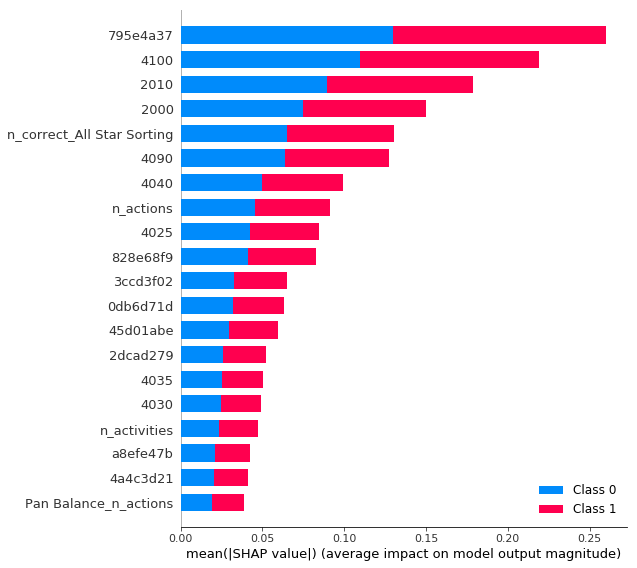

In [13]:
with open("../dsb2019/models/regression_baseline_adv_params.json", "r") as f:
    validator_params=json.load(f)
#validator_paramstor=best_params
selected_features = [f for f in train_features.columns if f not in ("installation_id", "game_session", "accuracy_group")]
validator = adv_validation.AdversarialValidator(validator_params, train_features, test_features, selected_features=selected_features,test_size=0.5)
validator.fit()
print(validator.roc_auc())
validator.shap_important_features()

In [14]:
subtrain_installations=pd.Series(train_features.installation_id.unique()).sample(frac=1., random_state=2019)
subtrain_features=train_features[train_features.installation_id.isin(subtrain_installations.values)].copy()
def check_hyperparams(params):
    print(params)
    if "max_depth" in params:
        params["max_depth"] = int(params["max_depth"])
    if "num_leaves" in params:
        params["num_leaves"] = int(params["num_leaves"])

    train_baseline_with_params = partial(train_baseline, params=params)
    cv=InstallationFold(n_splits=3)
    predictions = cross_validate(subtrain_features, subtrain_features.accuracy_group, make_features_wrapper, train_baseline_with_params, make_predictions,
                                cv=cv)
    return {
        "loss": np.mean([mean_squared_error(true, pred) for pred, true in predictions]),
        "status": STATUS_OK,
        "params": params
    }


def tune(check_params, n_tries=25, n_learning_rate_tries=15, learning_rate=None, n_estimators=10_000):        
    if learning_rate is None:
        learning_rate_space = {
            'learning_rate': hp.loguniform("learning_rate", np.log(0.005), np.log(0.3)),
            'metric': 'rmse',
            'objective': 'rmse',
            #'num_classes': 4,
            'random_state': 2019,
            "n_estimators": n_estimators,

        }
        trials = Trials()
        result = fmin(check_params,
                      learning_rate_space, tpe.suggest, n_learning_rate_tries, trials=trials)
        print(result)
        learning_rate = round(trials.best_trial["result"]["params"]["learning_rate"], 3)

    param_space = {
        'metric': 'rmse',
        'objective': 'rmse',
        #'num_classes': 4,
        'lambda_l1': hp.uniform("lamba_l1", 1e-10, 1),
        'lambda_l2': hp.uniform("lambda_l2", 1e-10, 1),
        'random_state': 2019,
        "n_estimators": n_estimators,
        "learning_rate": learning_rate,
        "max_depth": hp.quniform("max_depth", 2, 16, 1),
        "num_leaves": hp.choice("num_leaves", [3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]),
        "subsample": hp.quniform("subsample", 0.01, 1, 0.01),
        "feature_fraction": hp.quniform("feature_fraction", 0.01, 1, 0.01),
    }

    trials = Trials()
    fmin(check_params,
         param_space, tpe.suggest, n_tries, trials=trials)
    best_params = trials.best_trial["result"]["params"]
    return best_params

In [15]:
best_params=tune(check_hyperparams, n_tries=100, n_learning_rate_tries=10)

{'learning_rate': 0.013568589940712377, 'metric': 'rmse', 'n_estimators': 10000, 'objective': 'rmse', 'random_state': 2019}
  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.04364                       
[200]	valid_0's rmse: 1.01138                       
[300]	valid_0's rmse: 0.999012                      
[400]	valid_0's rmse: 0.995676                      
[500]	valid_0's rmse: 0.994103                      
[600]	valid_0's rmse: 0.992287                      
[700]	valid_0's rmse: 0.992409                      
[800]	valid_0's rmse: 0.992487                      
[900]	valid_0's rmse: 0.993329                      
[1000]	valid_0's rmse: 0.995046                     
[1100]	valid_0's rmse: 0.996074                     
[1200]	valid_0's rmse: 0.997452                     
[1300]	valid_0's rmse: 0.99868                      
[1400]	valid_0's rmse: 1.00011                      
[1500]	valid_0's rmse: 1.00155                      
[1600]	valid_0's rmse: 1.00354                      
[1700]	valid_0's rmse: 1.00529                      
[1800]	valid_0's rmse: 1.00705      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.01185                                                
[200]	valid_0's rmse: 1.03027                                                
[300]	valid_0's rmse: 1.0438                                                 
[400]	valid_0's rmse: 1.05377                                                
[500]	valid_0's rmse: 1.06328                                                
[600]	valid_0's rmse: 1.0691                                                 
[700]	valid_0's rmse: 1.07405                                                
[800]	valid_0's rmse: 1.08011                                                
[900]	valid_0's rmse: 1.08472                                                
[1000]	valid_0's rmse: 1.08752                                               
[1100]	valid_0's rmse: 1.09012                                               
[1200]	valid_0's rmse: 1.09295                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.07681                                                
[200]	valid_0's rmse: 1.02894                                                
[300]	valid_0's rmse: 1.0124                                                 
[400]	valid_0's rmse: 1.00219                                                
[500]	valid_0's rmse: 0.998346                                               
[600]	valid_0's rmse: 0.99731                                                
[700]	valid_0's rmse: 0.99661                                                
[800]	valid_0's rmse: 0.9961                                                 
[900]	valid_0's rmse: 0.995443                                               
[1000]	valid_0's rmse: 0.994924                                              
[1100]	valid_0's rmse: 0.994782                                              
[1200]	valid_0's rmse: 0.995279                                 

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 0.997431                                                
[200]	valid_0's rmse: 1.00462                                                 
[300]	valid_0's rmse: 1.01549                                                 
[400]	valid_0's rmse: 1.02588                                                 
[500]	valid_0's rmse: 1.03405                                                 
[600]	valid_0's rmse: 1.04052                                                 
[700]	valid_0's rmse: 1.04748                                                 
[800]	valid_0's rmse: 1.0517                                                  
[900]	valid_0's rmse: 1.05523                                                 
[1000]	valid_0's rmse: 1.06024                                                
[1100]	valid_0's rmse: 1.06338                                                
[1200]	valid_0's rmse: 1.06631                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 0.995832                                               
[200]	valid_0's rmse: 1.00473                                                
[300]	valid_0's rmse: 1.01537                                                
[400]	valid_0's rmse: 1.02114                                                
[500]	valid_0's rmse: 1.03132                                                
[600]	valid_0's rmse: 1.03853                                                
[700]	valid_0's rmse: 1.04453                                                
[800]	valid_0's rmse: 1.04959                                                
[900]	valid_0's rmse: 1.05398                                                
[1000]	valid_0's rmse: 1.05762                                               
[1100]	valid_0's rmse: 1.06042                                               
[1200]	valid_0's rmse: 1.06401                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.00071                                                
[200]	valid_0's rmse: 1.00587                                                
[300]	valid_0's rmse: 1.01562                                                
[400]	valid_0's rmse: 1.02499                                                
[500]	valid_0's rmse: 1.03318                                                
[600]	valid_0's rmse: 1.04054                                                
[700]	valid_0's rmse: 1.04567                                                
[800]	valid_0's rmse: 1.05083                                                
[900]	valid_0's rmse: 1.05481                                                
[1000]	valid_0's rmse: 1.05798                                               
[1100]	valid_0's rmse: 1.0612                                                
[1200]	valid_0's rmse: 1.06478                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 1.03848                                                 
[200]	valid_0's rmse: 1.06618                                                 
[300]	valid_0's rmse: 1.08445                                                 
[400]	valid_0's rmse: 1.09649                                                 
[500]	valid_0's rmse: 1.10213                                                 
[600]	valid_0's rmse: 1.10759                                                 
[700]	valid_0's rmse: 1.11207                                                 
[800]	valid_0's rmse: 1.11437                                                 
[900]	valid_0's rmse: 1.11446                                                 
[1000]	valid_0's rmse: 1.11699                                                
[1100]	valid_0's rmse: 1.11765                                                
[1200]	valid_0's rmse: 1.11898                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 0.998907                                               
[200]	valid_0's rmse: 0.994516                                               
[300]	valid_0's rmse: 0.996797                                               
[400]	valid_0's rmse: 0.998369                                               
[500]	valid_0's rmse: 1.00184                                                
[600]	valid_0's rmse: 1.00591                                                
[700]	valid_0's rmse: 1.01003                                                
[800]	valid_0's rmse: 1.01335                                                
[900]	valid_0's rmse: 1.01677                                                
[1000]	valid_0's rmse: 1.02048                                               
[1100]	valid_0's rmse: 1.02299                                               
[1200]	valid_0's rmse: 1.02649                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.00069                                                
[200]	valid_0's rmse: 1.01429                                                
[300]	valid_0's rmse: 1.02239                                                
[400]	valid_0's rmse: 1.0335                                                 
[500]	valid_0's rmse: 1.0389                                                 
[600]	valid_0's rmse: 1.04595                                                
[700]	valid_0's rmse: 1.05159                                                
[800]	valid_0's rmse: 1.05649                                                
[900]	valid_0's rmse: 1.06069                                                
[1000]	valid_0's rmse: 1.06272                                               
[1100]	valid_0's rmse: 1.06628                                               
[1200]	valid_0's rmse: 1.06903                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 0.999361                                               
[200]	valid_0's rmse: 1.01329                                                
[300]	valid_0's rmse: 1.02242                                                
[400]	valid_0's rmse: 1.03449                                                
[500]	valid_0's rmse: 1.04265                                                
[600]	valid_0's rmse: 1.0496                                                 
[700]	valid_0's rmse: 1.0573                                                 
[800]	valid_0's rmse: 1.06203                                                
[900]	valid_0's rmse: 1.06569                                                
[1000]	valid_0's rmse: 1.06781                                               
[1100]	valid_0's rmse: 1.07018                                               
[1200]	valid_0's rmse: 1.07228                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.19037                        
[200]	valid_0's rmse: 1.14959                        
[300]	valid_0's rmse: 1.13175                        
[400]	valid_0's rmse: 1.1193                         
[500]	valid_0's rmse: 1.11138                        
[600]	valid_0's rmse: 1.10277                        
[700]	valid_0's rmse: 1.08834                        
[800]	valid_0's rmse: 1.08355                        
[900]	valid_0's rmse: 1.07455                        
[1000]	valid_0's rmse: 1.07173                       
[1100]	valid_0's rmse: 1.06627                       
[1200]	valid_0's rmse: 1.06366                       
[1300]	valid_0's rmse: 1.06124                       
[1400]	valid_0's rmse: 1.05904                       
[1500]	valid_0's rmse: 1.05847                       
[1600]	valid_0's rmse: 1.05687                       
[1700]	valid_0's rmse: 1.05395                       
[1800]	valid_0's rm

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.14118                                                   
[200]	valid_0's rmse: 1.08085                                                   
[300]	valid_0's rmse: 1.05049                                                   
[400]	valid_0's rmse: 1.03518                                                   
[500]	valid_0's rmse: 1.02187                                                   
[600]	valid_0's rmse: 1.01473                                                   
[700]	valid_0's rmse: 1.00961                                                   
[800]	valid_0's rmse: 1.00697                                                   
[900]	valid_0's rmse: 1.00494                                                   
[1000]	valid_0's rmse: 1.00371                                                  
[1100]	valid_0's rmse: 1.00308                                                  
[1200]	valid_0's rmse: 1.002

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.2058                                                   
[200]	valid_0's rmse: 1.17123                                                  
[300]	valid_0's rmse: 1.14558                                                  
[400]	valid_0's rmse: 1.12703                                                  
[500]	valid_0's rmse: 1.10935                                                  
[600]	valid_0's rmse: 1.09629                                                  
[700]	valid_0's rmse: 1.08642                                                  
[800]	valid_0's rmse: 1.07707                                                  
[900]	valid_0's rmse: 1.0679                                                   
[1000]	valid_0's rmse: 1.06082                                                 
[1100]	valid_0's rmse: 1.05566                                                 
[1200]	valid_0's rmse: 1.0496           

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.18836                                                  
[200]	valid_0's rmse: 1.14963                                                  
[300]	valid_0's rmse: 1.12845                                                  
[400]	valid_0's rmse: 1.10781                                                  
[500]	valid_0's rmse: 1.09284                                                  
[600]	valid_0's rmse: 1.08095                                                  
[700]	valid_0's rmse: 1.07251                                                  
[800]	valid_0's rmse: 1.06567                                                  
[900]	valid_0's rmse: 1.06                                                     
[1000]	valid_0's rmse: 1.05541                                                 
[1100]	valid_0's rmse: 1.05103                                                 
[1200]	valid_0's rmse: 1.04728          

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.11132                                                  
[200]	valid_0's rmse: 1.05355                                                  
[300]	valid_0's rmse: 1.03155                                                  
[400]	valid_0's rmse: 1.02195                                                  
[500]	valid_0's rmse: 1.01683                                                  
[600]	valid_0's rmse: 1.01466                                                  
[700]	valid_0's rmse: 1.01394                                                  
[800]	valid_0's rmse: 1.01404                                                  
[900]	valid_0's rmse: 1.01435                                                  
[1000]	valid_0's rmse: 1.01476                                                 
[1100]	valid_0's rmse: 1.01598                                                 
[1200]	valid_0's rmse: 1.01683          

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.19282                                                   
[200]	valid_0's rmse: 1.15303                                                   
[300]	valid_0's rmse: 1.13117                                                   
[400]	valid_0's rmse: 1.11239                                                   
[500]	valid_0's rmse: 1.09599                                                   
[600]	valid_0's rmse: 1.08308                                                   
[700]	valid_0's rmse: 1.07368                                                   
[800]	valid_0's rmse: 1.06583                                                   
[900]	valid_0's rmse: 1.06027                                                   
[1000]	valid_0's rmse: 1.05529                                                  
[1100]	valid_0's rmse: 1.05099                                                  
[1200]	valid_0's rmse: 1.047

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.10661                                                   
[200]	valid_0's rmse: 1.03783                                                   
[300]	valid_0's rmse: 1.01017                                                   
[400]	valid_0's rmse: 0.998822                                                  
[500]	valid_0's rmse: 0.994177                                                  
[600]	valid_0's rmse: 0.992861                                                  
[700]	valid_0's rmse: 0.99247                                                   
[800]	valid_0's rmse: 0.992287                                                  
[900]	valid_0's rmse: 0.992697                                                  
[1000]	valid_0's rmse: 0.993856                                                 
[1100]	valid_0's rmse: 0.994821                                                 
[1200]	valid_0's rmse: 0.995

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13607                                                    
[200]	valid_0's rmse: 1.06987                                                    
[300]	valid_0's rmse: 1.03839                                                    
[400]	valid_0's rmse: 1.02116                                                    
[500]	valid_0's rmse: 1.01182                                                    
[600]	valid_0's rmse: 1.00681                                                    
[700]	valid_0's rmse: 1.00374                                                    
[800]	valid_0's rmse: 1.00124                                                    
[900]	valid_0's rmse: 0.999897                                                   
[1000]	valid_0's rmse: 0.998547                                                  
[1100]	valid_0's rmse: 0.9979                                                    
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.09096                                                   
[200]	valid_0's rmse: 1.02665                                                   
[300]	valid_0's rmse: 1.00527                                                   
[400]	valid_0's rmse: 0.996732                                                  
[500]	valid_0's rmse: 0.994297                                                  
[600]	valid_0's rmse: 0.993416                                                  
[700]	valid_0's rmse: 0.993422                                                  
[800]	valid_0's rmse: 0.993289                                                  
[900]	valid_0's rmse: 0.993233                                                  
[1000]	valid_0's rmse: 0.993831                                                 
[1100]	valid_0's rmse: 0.994756                                                 
[1200]	valid_0's rmse: 0.995

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15763                                                    
[200]	valid_0's rmse: 1.09586                                                    
[300]	valid_0's rmse: 1.06063                                                    
[400]	valid_0's rmse: 1.04089                                                    
[500]	valid_0's rmse: 1.02508                                                    
[600]	valid_0's rmse: 1.01476                                                    
[700]	valid_0's rmse: 1.00886                                                    
[800]	valid_0's rmse: 1.00523                                                    
[900]	valid_0's rmse: 1.00247                                                    
[1000]	valid_0's rmse: 1.00063                                                   
[1100]	valid_0's rmse: 0.999604                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09838                                                    
[200]	valid_0's rmse: 1.04575                                                    
[300]	valid_0's rmse: 1.02578                                                    
[400]	valid_0's rmse: 1.01379                                                    
[500]	valid_0's rmse: 1.00712                                                    
[600]	valid_0's rmse: 1.00411                                                    
[700]	valid_0's rmse: 1.00244                                                    
[800]	valid_0's rmse: 1.00115                                                    
[900]	valid_0's rmse: 1.00018                                                    
[1000]	valid_0's rmse: 0.999156                                                  
[1100]	valid_0's rmse: 0.998729                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08619                                                    
[200]	valid_0's rmse: 1.02912                                                    
[300]	valid_0's rmse: 1.01114                                                    
[400]	valid_0's rmse: 1.00268                                                    
[500]	valid_0's rmse: 0.998693                                                   
[600]	valid_0's rmse: 0.997089                                                   
[700]	valid_0's rmse: 0.996322                                                   
[800]	valid_0's rmse: 0.996084                                                   
[900]	valid_0's rmse: 0.995702                                                   
[1000]	valid_0's rmse: 0.995262                                                  
[1100]	valid_0's rmse: 0.995167                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.16521                                                     
[200]	valid_0's rmse: 1.11875                                                     
[300]	valid_0's rmse: 1.08438                                                     
[400]	valid_0's rmse: 1.06281                                                     
[500]	valid_0's rmse: 1.0421                                                      
[600]	valid_0's rmse: 1.02899                                                     
[700]	valid_0's rmse: 1.01973                                                     
[800]	valid_0's rmse: 1.01438                                                     
[900]	valid_0's rmse: 1.00979                                                     
[1000]	valid_0's rmse: 1.00703                                                    
[1100]	valid_0's rmse: 1.00557                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12959                                                    
[200]	valid_0's rmse: 1.08888                                                    
[300]	valid_0's rmse: 1.06682                                                    
[400]	valid_0's rmse: 1.05294                                                    
[500]	valid_0's rmse: 1.04128                                                    
[600]	valid_0's rmse: 1.03296                                                    
[700]	valid_0's rmse: 1.02657                                                    
[800]	valid_0's rmse: 1.02241                                                    
[900]	valid_0's rmse: 1.01947                                                    
[1000]	valid_0's rmse: 1.017                                                     
[1100]	valid_0's rmse: 1.01522                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07265                                                    
[200]	valid_0's rmse: 1.01467                                                    
[300]	valid_0's rmse: 0.998862                                                   
[400]	valid_0's rmse: 0.992881                                                   
[500]	valid_0's rmse: 0.989766                                                   
[600]	valid_0's rmse: 0.989087                                                   
[700]	valid_0's rmse: 0.988655                                                   
[800]	valid_0's rmse: 0.988436                                                   
[900]	valid_0's rmse: 0.988484                                                   
[1000]	valid_0's rmse: 0.988557                                                  
[1100]	valid_0's rmse: 0.988381                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.19179                                                     
[200]	valid_0's rmse: 1.16343                                                     
[300]	valid_0's rmse: 1.13436                                                     
[400]	valid_0's rmse: 1.11178                                                     
[500]	valid_0's rmse: 1.09661                                                     
[600]	valid_0's rmse: 1.08584                                                     
[700]	valid_0's rmse: 1.07524                                                     
[800]	valid_0's rmse: 1.06786                                                     
[900]	valid_0's rmse: 1.06004                                                     
[1000]	valid_0's rmse: 1.05444                                                    
[1100]	valid_0's rmse: 1.04826                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.21331                                                    
[200]	valid_0's rmse: 1.18665                                                    
[300]	valid_0's rmse: 1.1627                                                     
[400]	valid_0's rmse: 1.14488                                                    
[500]	valid_0's rmse: 1.1278                                                     
[600]	valid_0's rmse: 1.11582                                                    
[700]	valid_0's rmse: 1.10595                                                    
[800]	valid_0's rmse: 1.09809                                                    
[900]	valid_0's rmse: 1.09098                                                    
[1000]	valid_0's rmse: 1.08515                                                   
[1100]	valid_0's rmse: 1.08037                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13867                                                    
[200]	valid_0's rmse: 1.07334                                                    
[300]	valid_0's rmse: 1.03849                                                    
[400]	valid_0's rmse: 1.02118                                                    
[500]	valid_0's rmse: 1.00959                                                    
[600]	valid_0's rmse: 1.00269                                                    
[700]	valid_0's rmse: 0.99909                                                    
[800]	valid_0's rmse: 0.997239                                                   
[900]	valid_0's rmse: 0.995688                                                   
[1000]	valid_0's rmse: 0.994715                                                  
[1100]	valid_0's rmse: 0.9939                                                    
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15849                                                    
[200]	valid_0's rmse: 1.09846                                                    
[300]	valid_0's rmse: 1.06458                                                    
[400]	valid_0's rmse: 1.04403                                                    
[500]	valid_0's rmse: 1.02676                                                    
[600]	valid_0's rmse: 1.01613                                                    
[700]	valid_0's rmse: 1.00955                                                    
[800]	valid_0's rmse: 1.00572                                                    
[900]	valid_0's rmse: 1.00235                                                    
[1000]	valid_0's rmse: 1.00062                                                   
[1100]	valid_0's rmse: 0.999886                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1262                                                     
[200]	valid_0's rmse: 1.08283                                                    
[300]	valid_0's rmse: 1.0609                                                     
[400]	valid_0's rmse: 1.0461                                                     
[500]	valid_0's rmse: 1.03595                                                    
[600]	valid_0's rmse: 1.02899                                                    
[700]	valid_0's rmse: 1.02368                                                    
[800]	valid_0's rmse: 1.01977                                                    
[900]	valid_0's rmse: 1.01706                                                    
[1000]	valid_0's rmse: 1.01521                                                   
[1100]	valid_0's rmse: 1.01372                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.0932                                                     
[200]	valid_0's rmse: 1.03203                                                    
[300]	valid_0's rmse: 1.00952                                                    
[400]	valid_0's rmse: 1.00022                                                    
[500]	valid_0's rmse: 0.995312                                                   
[600]	valid_0's rmse: 0.993793                                                   
[700]	valid_0's rmse: 0.992962                                                   
[800]	valid_0's rmse: 0.993017                                                   
[900]	valid_0's rmse: 0.992619                                                   
[1000]	valid_0's rmse: 0.992373                                                  
[1100]	valid_0's rmse: 0.992391                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07617                                                    
[200]	valid_0's rmse: 1.01626                                                    
[300]	valid_0's rmse: 1.0017                                                     
[400]	valid_0's rmse: 0.998013                                                   
[500]	valid_0's rmse: 0.997817                                                   
[600]	valid_0's rmse: 0.998323                                                   
[700]	valid_0's rmse: 0.998879                                                   
[800]	valid_0's rmse: 0.999769                                                   
[900]	valid_0's rmse: 1.00081                                                    
[1000]	valid_0's rmse: 1.00201                                                   
[1100]	valid_0's rmse: 1.00333                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.05968                                                     
[200]	valid_0's rmse: 1.01122                                                     
[300]	valid_0's rmse: 0.997205                                                    
[400]	valid_0's rmse: 0.990502                                                    
[500]	valid_0's rmse: 0.988887                                                    
[600]	valid_0's rmse: 0.989912                                                    
[700]	valid_0's rmse: 0.990083                                                    
[800]	valid_0's rmse: 0.99113                                                     
[900]	valid_0's rmse: 0.992128                                                    
[1000]	valid_0's rmse: 0.993146                                                   
[1100]	valid_0's rmse: 0.993964                                                   
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.10451                                                     
[200]	valid_0's rmse: 1.03754                                                     
[300]	valid_0's rmse: 1.01216                                                     
[400]	valid_0's rmse: 1.00061                                                     
[500]	valid_0's rmse: 0.995181                                                    
[600]	valid_0's rmse: 0.992593                                                    
[700]	valid_0's rmse: 0.991422                                                    
[800]	valid_0's rmse: 0.990494                                                    
[900]	valid_0's rmse: 0.990103                                                    
[1000]	valid_0's rmse: 0.98991                                                    
[1100]	valid_0's rmse: 0.989567                                                   
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.09718                                                     
[200]	valid_0's rmse: 1.03426                                                     
[300]	valid_0's rmse: 1.0105                                                      
[400]	valid_0's rmse: 0.99997                                                     
[500]	valid_0's rmse: 0.995176                                                    
[600]	valid_0's rmse: 0.992921                                                    
[700]	valid_0's rmse: 0.992139                                                    
[800]	valid_0's rmse: 0.991603                                                    
[900]	valid_0's rmse: 0.990967                                                    
[1000]	valid_0's rmse: 0.990355                                                   
[1100]	valid_0's rmse: 0.990411                                                   
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1018                                                     
[200]	valid_0's rmse: 1.03706                                                    
[300]	valid_0's rmse: 1.012                                                      
[400]	valid_0's rmse: 1.00069                                                    
[500]	valid_0's rmse: 0.995797                                                   
[600]	valid_0's rmse: 0.993004                                                   
[700]	valid_0's rmse: 0.991497                                                   
[800]	valid_0's rmse: 0.99068                                                    
[900]	valid_0's rmse: 0.990095                                                   
[1000]	valid_0's rmse: 0.989494                                                  
[1100]	valid_0's rmse: 0.989465                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10822                                                    
[200]	valid_0's rmse: 1.03881                                                    
[300]	valid_0's rmse: 1.01192                                                    
[400]	valid_0's rmse: 1.00102                                                    
[500]	valid_0's rmse: 0.996102                                                   
[600]	valid_0's rmse: 0.993542                                                   
[700]	valid_0's rmse: 0.99221                                                    
[800]	valid_0's rmse: 0.991185                                                   
[900]	valid_0's rmse: 0.990537                                                   
[1000]	valid_0's rmse: 0.990173                                                  
[1100]	valid_0's rmse: 0.990084                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06591                                                    
[200]	valid_0's rmse: 1.0117                                                     
[300]	valid_0's rmse: 0.998731                                                   
[400]	valid_0's rmse: 0.996861                                                   
[500]	valid_0's rmse: 0.99773                                                    
[600]	valid_0's rmse: 0.999427                                                   
[700]	valid_0's rmse: 1.0005                                                     
[800]	valid_0's rmse: 1.0013                                                     
[900]	valid_0's rmse: 1.00303                                                    
[1000]	valid_0's rmse: 1.00453                                                   
[1100]	valid_0's rmse: 1.00599                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07622                                                    
[200]	valid_0's rmse: 1.02767                                                    
[300]	valid_0's rmse: 1.01018                                                    
[400]	valid_0's rmse: 1.00021                                                    
[500]	valid_0's rmse: 0.99584                                                    
[600]	valid_0's rmse: 0.994374                                                   
[700]	valid_0's rmse: 0.993999                                                   
[800]	valid_0's rmse: 0.993251                                                   
[900]	valid_0's rmse: 0.992302                                                   
[1000]	valid_0's rmse: 0.992214                                                  
[1100]	valid_0's rmse: 0.991447                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12136                                                    
[200]	valid_0's rmse: 1.05783                                                    
[300]	valid_0's rmse: 1.02973                                                    
[400]	valid_0's rmse: 1.01807                                                    
[500]	valid_0's rmse: 1.01134                                                    
[600]	valid_0's rmse: 1.00757                                                    
[700]	valid_0's rmse: 1.00635                                                    
[800]	valid_0's rmse: 1.00538                                                    
[900]	valid_0's rmse: 1.00508                                                    
[1000]	valid_0's rmse: 1.0054                                                    
[1100]	valid_0's rmse: 1.00595                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11255                                                    
[200]	valid_0's rmse: 1.05326                                                    
[300]	valid_0's rmse: 1.0313                                                     
[400]	valid_0's rmse: 1.02074                                                    
[500]	valid_0's rmse: 1.0163                                                     
[600]	valid_0's rmse: 1.01427                                                    
[700]	valid_0's rmse: 1.01339                                                    
[800]	valid_0's rmse: 1.01307                                                    
[900]	valid_0's rmse: 1.01361                                                    
[1000]	valid_0's rmse: 1.01426                                                   
[1100]	valid_0's rmse: 1.01531                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.0938                                                       
[200]	valid_0's rmse: 1.03185                                                      
[300]	valid_0's rmse: 1.01308                                                      
[400]	valid_0's rmse: 1.00784                                                      
[500]	valid_0's rmse: 1.00647                                                      
[600]	valid_0's rmse: 1.00693                                                      
[700]	valid_0's rmse: 1.00772                                                      
[800]	valid_0's rmse: 1.00931                                                      
[900]	valid_0's rmse: 1.01074                                                      
[1000]	valid_0's rmse: 1.01225                                                     
[1100]	valid_0's rmse: 1.01344                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.08142                                                      
[200]	valid_0's rmse: 1.02248                                                      
[300]	valid_0's rmse: 1.00579                                                      
[400]	valid_0's rmse: 1.00246                                                      
[500]	valid_0's rmse: 1.00228                                                      
[600]	valid_0's rmse: 1.00298                                                      
[700]	valid_0's rmse: 1.00395                                                      
[800]	valid_0's rmse: 1.00532                                                      
[900]	valid_0's rmse: 1.00658                                                      
[1000]	valid_0's rmse: 1.00816                                                     
[1100]	valid_0's rmse: 1.00943                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.06914                                                      
[200]	valid_0's rmse: 1.01242                                                      
[300]	valid_0's rmse: 0.998885                                                     
[400]	valid_0's rmse: 0.995415                                                     
[500]	valid_0's rmse: 0.99521                                                      
[600]	valid_0's rmse: 0.995843                                                     
[700]	valid_0's rmse: 0.996598                                                     
[800]	valid_0's rmse: 0.997904                                                     
[900]	valid_0's rmse: 0.999372                                                     
[1000]	valid_0's rmse: 1.00101                                                     
[1100]	valid_0's rmse: 1.00221                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.11272                                                      
[200]	valid_0's rmse: 1.04326                                                      
[300]	valid_0's rmse: 1.0153                                                       
[400]	valid_0's rmse: 1.00316                                                      
[500]	valid_0's rmse: 0.997652                                                     
[600]	valid_0's rmse: 0.995208                                                     
[700]	valid_0's rmse: 0.993334                                                     
[800]	valid_0's rmse: 0.99272                                                      
[900]	valid_0's rmse: 0.992447                                                     
[1000]	valid_0's rmse: 0.992011                                                    
[1100]	valid_0's rmse: 0.991595                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.22562                                                      
[200]	valid_0's rmse: 1.20721                                                      
[300]	valid_0's rmse: 1.19414                                                      
[400]	valid_0's rmse: 1.1824                                                       
[500]	valid_0's rmse: 1.17319                                                      
[600]	valid_0's rmse: 1.16361                                                      
[700]	valid_0's rmse: 1.15659                                                      
[800]	valid_0's rmse: 1.15128                                                      
[900]	valid_0's rmse: 1.14444                                                      
[1000]	valid_0's rmse: 1.13823                                                     
[1100]	valid_0's rmse: 1.13556                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.11329                                                      
[200]	valid_0's rmse: 1.04921                                                      
[300]	valid_0's rmse: 1.02638                                                      
[400]	valid_0's rmse: 1.01633                                                      
[500]	valid_0's rmse: 1.01234                                                      
[600]	valid_0's rmse: 1.01048                                                      
[700]	valid_0's rmse: 1.00974                                                      
[800]	valid_0's rmse: 1.00948                                                      
[900]	valid_0's rmse: 1.00983                                                      
[1000]	valid_0's rmse: 1.01078                                                     
[1100]	valid_0's rmse: 1.01174                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.07706                                                      
[200]	valid_0's rmse: 1.02713                                                      
[300]	valid_0's rmse: 1.01026                                                      
[400]	valid_0's rmse: 1.00046                                                      
[500]	valid_0's rmse: 0.995718                                                     
[600]	valid_0's rmse: 0.993896                                                     
[700]	valid_0's rmse: 0.994074                                                     
[800]	valid_0's rmse: 0.994036                                                     
[900]	valid_0's rmse: 0.993359                                                     
[1000]	valid_0's rmse: 0.993045                                                    
[1100]	valid_0's rmse: 0.993052                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.10643                                                      
[200]	valid_0's rmse: 1.04395                                                      
[300]	valid_0's rmse: 1.02316                                                      
[400]	valid_0's rmse: 1.01481                                                      
[500]	valid_0's rmse: 1.01141                                                      
[600]	valid_0's rmse: 1.01068                                                      
[700]	valid_0's rmse: 1.01079                                                      
[800]	valid_0's rmse: 1.01095                                                      
[900]	valid_0's rmse: 1.01194                                                      
[1000]	valid_0's rmse: 1.01311                                                     
[1100]	valid_0's rmse: 1.01439                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.17411                                                      
[200]	valid_0's rmse: 1.1441                                                       
[300]	valid_0's rmse: 1.11829                                                      
[400]	valid_0's rmse: 1.1007                                                       
[500]	valid_0's rmse: 1.08873                                                      
[600]	valid_0's rmse: 1.07947                                                      
[700]	valid_0's rmse: 1.07174                                                      
[800]	valid_0's rmse: 1.06581                                                      
[900]	valid_0's rmse: 1.06064                                                      
[1000]	valid_0's rmse: 1.05583                                                     
[1100]	valid_0's rmse: 1.05128                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.08015                                                      
[200]	valid_0's rmse: 1.02034                                                      
[300]	valid_0's rmse: 1.0037                                                       
[400]	valid_0's rmse: 0.999672                                                     
[500]	valid_0's rmse: 0.999885                                                     
[600]	valid_0's rmse: 1.00073                                                      
[700]	valid_0's rmse: 1.00171                                                      
[800]	valid_0's rmse: 1.00254                                                      
[900]	valid_0's rmse: 1.00404                                                      
[1000]	valid_0's rmse: 1.00525                                                     
[1100]	valid_0's rmse: 1.00616                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.10236                                                      
[200]	valid_0's rmse: 1.03381                                                      
[300]	valid_0's rmse: 1.00922                                                      
[400]	valid_0's rmse: 1.00014                                                      
[500]	valid_0's rmse: 0.997306                                                     
[600]	valid_0's rmse: 0.99636                                                      
[700]	valid_0's rmse: 0.996692                                                     
[800]	valid_0's rmse: 0.997411                                                     
[900]	valid_0's rmse: 0.998225                                                     
[1000]	valid_0's rmse: 0.999194                                                    
[1100]	valid_0's rmse: 0.999712                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.06556                                                      
[200]	valid_0's rmse: 1.00976                                                      
[300]	valid_0's rmse: 0.997471                                                     
[400]	valid_0's rmse: 0.996235                                                     
[500]	valid_0's rmse: 0.997779                                                     
[600]	valid_0's rmse: 0.999427                                                     
[700]	valid_0's rmse: 1.00073                                                      
[800]	valid_0's rmse: 1.00191                                                      
[900]	valid_0's rmse: 1.00354                                                      
[1000]	valid_0's rmse: 1.00553                                                     
[1100]	valid_0's rmse: 1.00758                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.13916                                                      
[200]	valid_0's rmse: 1.07219                                                      
[300]	valid_0's rmse: 1.04019                                                      
[400]	valid_0's rmse: 1.02204                                                      
[500]	valid_0's rmse: 1.01255                                                      
[600]	valid_0's rmse: 1.00701                                                      
[700]	valid_0's rmse: 1.00415                                                      
[800]	valid_0's rmse: 1.00204                                                      
[900]	valid_0's rmse: 1.00027                                                      
[1000]	valid_0's rmse: 0.998807                                                    
[1100]	valid_0's rmse: 0.997606                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.07926                                                      
[200]	valid_0's rmse: 1.02792                                                      
[300]	valid_0's rmse: 1.01099                                                      
[400]	valid_0's rmse: 1.00215                                                      
[500]	valid_0's rmse: 0.997127                                                     
[600]	valid_0's rmse: 0.995733                                                     
[700]	valid_0's rmse: 0.995989                                                     
[800]	valid_0's rmse: 0.995115                                                     
[900]	valid_0's rmse: 0.994718                                                     
[1000]	valid_0's rmse: 0.994064                                                    
[1100]	valid_0's rmse: 0.993836                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.16546                                                      
[200]	valid_0's rmse: 1.13065                                                      
[300]	valid_0's rmse: 1.10437                                                      
[400]	valid_0's rmse: 1.08685                                                      
[500]	valid_0's rmse: 1.0745                                                       
[600]	valid_0's rmse: 1.06506                                                      
[700]	valid_0's rmse: 1.05838                                                      
[800]	valid_0's rmse: 1.05258                                                      
[900]	valid_0's rmse: 1.04742                                                      
[1000]	valid_0's rmse: 1.04298                                                     
[1100]	valid_0's rmse: 1.03868                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.11819                                                      
[200]	valid_0's rmse: 1.05978                                                      
[300]	valid_0's rmse: 1.03551                                                      
[400]	valid_0's rmse: 1.0256                                                       
[500]	valid_0's rmse: 1.01983                                                      
[600]	valid_0's rmse: 1.01681                                                      
[700]	valid_0's rmse: 1.01606                                                      
[800]	valid_0's rmse: 1.01609                                                      
[900]	valid_0's rmse: 1.01645                                                      
[1000]	valid_0's rmse: 1.01678                                                     
[1100]	valid_0's rmse: 1.01768                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.10621                                                      
[200]	valid_0's rmse: 1.03746                                                      
[300]	valid_0's rmse: 1.01142                                                      
[400]	valid_0's rmse: 1.00137                                                      
[500]	valid_0's rmse: 0.997195                                                     
[600]	valid_0's rmse: 0.996079                                                     
[700]	valid_0's rmse: 0.995439                                                     
[800]	valid_0's rmse: 0.995041                                                     
[900]	valid_0's rmse: 0.995028                                                     
[1000]	valid_0's rmse: 0.994973                                                    
[1100]	valid_0's rmse: 0.995294                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.11417                                                      
[200]	valid_0's rmse: 1.06705                                                      
[300]	valid_0's rmse: 1.04457                                                      
[400]	valid_0's rmse: 1.03139                                                      
[500]	valid_0's rmse: 1.02127                                                      
[600]	valid_0's rmse: 1.01581                                                      
[700]	valid_0's rmse: 1.01248                                                      
[800]	valid_0's rmse: 1.01008                                                      
[900]	valid_0's rmse: 1.00892                                                      
[1000]	valid_0's rmse: 1.00771                                                     
[1100]	valid_0's rmse: 1.0067                                               

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.13735                                                      
[200]	valid_0's rmse: 1.0875                                                       
[300]	valid_0's rmse: 1.06306                                                      
[400]	valid_0's rmse: 1.04785                                                      
[500]	valid_0's rmse: 1.03732                                                      
[600]	valid_0's rmse: 1.02937                                                      
[700]	valid_0's rmse: 1.02379                                                      
[800]	valid_0's rmse: 1.02019                                                      
[900]	valid_0's rmse: 1.01738                                                      
[1000]	valid_0's rmse: 1.01532                                                     
[1100]	valid_0's rmse: 1.01374                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.20654                                                      
[200]	valid_0's rmse: 1.17048                                                      
[300]	valid_0's rmse: 1.14653                                                      
[400]	valid_0's rmse: 1.12988                                                      
[500]	valid_0's rmse: 1.11477                                                      
[600]	valid_0's rmse: 1.1034                                                       
[700]	valid_0's rmse: 1.09143                                                      
[800]	valid_0's rmse: 1.08121                                                      
[900]	valid_0's rmse: 1.0728                                                       
[1000]	valid_0's rmse: 1.06594                                                     
[1100]	valid_0's rmse: 1.0608                                               

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.13363                                                      
[200]	valid_0's rmse: 1.06872                                                      
[300]	valid_0's rmse: 1.03669                                                      
[400]	valid_0's rmse: 1.02013                                                      
[500]	valid_0's rmse: 1.01141                                                      
[600]	valid_0's rmse: 1.00659                                                      
[700]	valid_0's rmse: 1.00347                                                      
[800]	valid_0's rmse: 1.00141                                                      
[900]	valid_0's rmse: 0.999973                                                     
[1000]	valid_0's rmse: 0.998832                                                    
[1100]	valid_0's rmse: 0.997681                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.15939                                                     
[200]	valid_0's rmse: 1.11657                                                     
[300]	valid_0's rmse: 1.08333                                                     
[400]	valid_0's rmse: 1.06288                                                     
[500]	valid_0's rmse: 1.04304                                                     
[600]	valid_0's rmse: 1.03148                                                     
[700]	valid_0's rmse: 1.02336                                                     
[800]	valid_0's rmse: 1.01829                                                     
[900]	valid_0's rmse: 1.01338                                                     
[1000]	valid_0's rmse: 1.00985                                                    
[1100]	valid_0's rmse: 1.00851                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.08571                                                      
[200]	valid_0's rmse: 1.0237                                                       
[300]	valid_0's rmse: 1.00478                                                      
[400]	valid_0's rmse: 0.999298                                                     
[500]	valid_0's rmse: 0.997383                                                     
[600]	valid_0's rmse: 0.997261                                                     
[700]	valid_0's rmse: 0.998266                                                     
[800]	valid_0's rmse: 0.999157                                                     
[900]	valid_0's rmse: 0.999744                                                     
[1000]	valid_0's rmse: 1.00081                                                     
[1100]	valid_0's rmse: 1.00183                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.08587                                                      
[200]	valid_0's rmse: 1.02232                                                      
[300]	valid_0's rmse: 1.00036                                                      
[400]	valid_0's rmse: 0.993417                                                     
[500]	valid_0's rmse: 0.991022                                                     
[600]	valid_0's rmse: 0.990538                                                     
[700]	valid_0's rmse: 0.990567                                                     
[800]	valid_0's rmse: 0.991104                                                     
[900]	valid_0's rmse: 0.991524                                                     
[1000]	valid_0's rmse: 0.992957                                                    
[1100]	valid_0's rmse: 0.99406                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.139                                                        
[200]	valid_0's rmse: 1.07484                                                      
[300]	valid_0's rmse: 1.04089                                                      
[400]	valid_0's rmse: 1.02448                                                      
[500]	valid_0's rmse: 1.01138                                                      
[600]	valid_0's rmse: 1.0039                                                       
[700]	valid_0's rmse: 0.999677                                                     
[800]	valid_0's rmse: 0.996902                                                     
[900]	valid_0's rmse: 0.994922                                                     
[1000]	valid_0's rmse: 0.993701                                                    
[1100]	valid_0's rmse: 0.993139                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.09661                                                      
[200]	valid_0's rmse: 1.04598                                                      
[300]	valid_0's rmse: 1.02675                                                      
[400]	valid_0's rmse: 1.0144                                                       
[500]	valid_0's rmse: 1.00784                                                      
[600]	valid_0's rmse: 1.00478                                                      
[700]	valid_0's rmse: 1.00272                                                      
[800]	valid_0's rmse: 1.0014                                                       
[900]	valid_0's rmse: 1.00062                                                      
[1000]	valid_0's rmse: 0.999886                                                    
[1100]	valid_0's rmse: 0.999469                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.07042                                                      
[200]	valid_0's rmse: 1.01269                                                      
[300]	valid_0's rmse: 1.00026                                                      
[400]	valid_0's rmse: 0.998098                                                     
[500]	valid_0's rmse: 0.998074                                                     
[600]	valid_0's rmse: 0.999725                                                     
[700]	valid_0's rmse: 1.00168                                                      
[800]	valid_0's rmse: 1.0029                                                       
[900]	valid_0's rmse: 1.00419                                                      
[1000]	valid_0's rmse: 1.00607                                                     
[1100]	valid_0's rmse: 1.00739                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.20204                                                      
[200]	valid_0's rmse: 1.1704                                                       
[300]	valid_0's rmse: 1.15032                                                      
[400]	valid_0's rmse: 1.12632                                                      
[500]	valid_0's rmse: 1.11065                                                      
[600]	valid_0's rmse: 1.09659                                                      
[700]	valid_0's rmse: 1.08877                                                      
[800]	valid_0's rmse: 1.08163                                                      
[900]	valid_0's rmse: 1.07637                                                      
[1000]	valid_0's rmse: 1.0696                                                      
[1100]	valid_0's rmse: 1.06495                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.12524                                                      
[200]	valid_0's rmse: 1.05599                                                      
[300]	valid_0's rmse: 1.02471                                                      
[400]	valid_0's rmse: 1.00802                                                      
[500]	valid_0's rmse: 0.999469                                                     
[600]	valid_0's rmse: 0.995507                                                     
[700]	valid_0's rmse: 0.993205                                                     
[800]	valid_0's rmse: 0.991757                                                     
[900]	valid_0's rmse: 0.990917                                                     
[1000]	valid_0's rmse: 0.990359                                                    
[1100]	valid_0's rmse: 0.989926                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.12467                                                      
[200]	valid_0's rmse: 1.08245                                                      
[300]	valid_0's rmse: 1.06086                                                      
[400]	valid_0's rmse: 1.04619                                                      
[500]	valid_0's rmse: 1.03564                                                      
[600]	valid_0's rmse: 1.02855                                                      
[700]	valid_0's rmse: 1.02351                                                      
[800]	valid_0's rmse: 1.01977                                                      
[900]	valid_0's rmse: 1.01709                                                      
[1000]	valid_0's rmse: 1.01545                                                     
[1100]	valid_0's rmse: 1.01407                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.17364                                                      
[200]	valid_0's rmse: 1.14257                                                      
[300]	valid_0's rmse: 1.11726                                                      
[400]	valid_0's rmse: 1.10039                                                      
[500]	valid_0's rmse: 1.0884                                                       
[600]	valid_0's rmse: 1.07889                                                      
[700]	valid_0's rmse: 1.07153                                                      
[800]	valid_0's rmse: 1.06561                                                      
[900]	valid_0's rmse: 1.06065                                                      
[1000]	valid_0's rmse: 1.05601                                                     
[1100]	valid_0's rmse: 1.05161                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.10707                                                      
[200]	valid_0's rmse: 1.03806                                                      
[300]	valid_0's rmse: 1.01005                                                      
[400]	valid_0's rmse: 0.998484                                                     
[500]	valid_0's rmse: 0.993138                                                     
[600]	valid_0's rmse: 0.991256                                                     
[700]	valid_0's rmse: 0.99115                                                      
[800]	valid_0's rmse: 0.991477                                                     
[900]	valid_0's rmse: 0.991834                                                     
[1000]	valid_0's rmse: 0.992957                                                    
[1100]	valid_0's rmse: 0.994151                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.11312                                                      
[200]	valid_0's rmse: 1.0558                                                       
[300]	valid_0's rmse: 1.03378                                                      
[400]	valid_0's rmse: 1.02405                                                      
[500]	valid_0's rmse: 1.01974                                                      
[600]	valid_0's rmse: 1.01738                                                      
[700]	valid_0's rmse: 1.01639                                                      
[800]	valid_0's rmse: 1.0162                                                       
[900]	valid_0's rmse: 1.01689                                                      
[1000]	valid_0's rmse: 1.01713                                                     
[1100]	valid_0's rmse: 1.01836                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.10786                                                      
[200]	valid_0's rmse: 1.03839                                                      
[300]	valid_0's rmse: 1.0117                                                       
[400]	valid_0's rmse: 1.00055                                                      
[500]	valid_0's rmse: 0.995727                                                     
[600]	valid_0's rmse: 0.993319                                                     
[700]	valid_0's rmse: 0.99172                                                      
[800]	valid_0's rmse: 0.990921                                                     
[900]	valid_0's rmse: 0.99042                                                      
[1000]	valid_0's rmse: 0.990396                                                    
[1100]	valid_0's rmse: 0.989944                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.1127                                                       
[200]	valid_0's rmse: 1.04321                                                      
[300]	valid_0's rmse: 1.0146                                                       
[400]	valid_0's rmse: 1.00216                                                      
[500]	valid_0's rmse: 0.997049                                                     
[600]	valid_0's rmse: 0.994541                                                     
[700]	valid_0's rmse: 0.993313                                                     
[800]	valid_0's rmse: 0.992287                                                     
[900]	valid_0's rmse: 0.991797                                                     
[1000]	valid_0's rmse: 0.991656                                                    
[1100]	valid_0's rmse: 0.991673                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.11102                                                      
[200]	valid_0's rmse: 1.04177                                                      
[300]	valid_0's rmse: 1.01459                                                      
[400]	valid_0's rmse: 1.00215                                                      
[500]	valid_0's rmse: 0.996608                                                     
[600]	valid_0's rmse: 0.994368                                                     
[700]	valid_0's rmse: 0.9924                                                       
[800]	valid_0's rmse: 0.991847                                                     
[900]	valid_0's rmse: 0.991176                                                     
[1000]	valid_0's rmse: 0.990743                                                    
[1100]	valid_0's rmse: 0.990335                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.12387                                                      
[200]	valid_0's rmse: 1.05295                                                      
[300]	valid_0's rmse: 1.0222                                                       
[400]	valid_0's rmse: 1.00631                                                      
[500]	valid_0's rmse: 0.998441                                                     
[600]	valid_0's rmse: 0.994144                                                     
[700]	valid_0's rmse: 0.99275                                                      
[800]	valid_0's rmse: 0.991392                                                     
[900]	valid_0's rmse: 0.991147                                                     
[1000]	valid_0's rmse: 0.990867                                                    
[1100]	valid_0's rmse: 0.990523                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09321                                                    
[200]	valid_0's rmse: 1.03203                                                    
[300]	valid_0's rmse: 1.00969                                                    
[400]	valid_0's rmse: 1.00019                                                    
[500]	valid_0's rmse: 0.994932                                                   
[600]	valid_0's rmse: 0.992876                                                   
[700]	valid_0's rmse: 0.992168                                                   
[800]	valid_0's rmse: 0.991867                                                   
[900]	valid_0's rmse: 0.991761                                                   
[1000]	valid_0's rmse: 0.991494                                                  
[1100]	valid_0's rmse: 0.991336                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.10786                                                   
[200]	valid_0's rmse: 1.03933                                                   
[300]	valid_0's rmse: 1.01251                                                   
[400]	valid_0's rmse: 1.00079                                                   
[500]	valid_0's rmse: 0.995811                                                  
[600]	valid_0's rmse: 0.993465                                                  
[700]	valid_0's rmse: 0.991877                                                  
[800]	valid_0's rmse: 0.990922                                                  
[900]	valid_0's rmse: 0.990425                                                  
[1000]	valid_0's rmse: 0.98976                                                  
[1100]	valid_0's rmse: 0.989457                                                 
[1200]	valid_0's rmse: 0.989

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.08168                                                      
[200]	valid_0's rmse: 1.02422                                                      
[300]	valid_0's rmse: 1.00789                                                      
[400]	valid_0's rmse: 1.00414                                                      
[500]	valid_0's rmse: 1.00413                                                      
[600]	valid_0's rmse: 1.00459                                                      
[700]	valid_0's rmse: 1.00598                                                      
[800]	valid_0's rmse: 1.00755                                                      
[900]	valid_0's rmse: 1.00906                                                      
[1000]	valid_0's rmse: 1.0102                                                      
[1100]	valid_0's rmse: 1.01145                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.13957                                                      
[200]	valid_0's rmse: 1.07461                                                      
[300]	valid_0's rmse: 1.04213                                                      
[400]	valid_0's rmse: 1.02391                                                      
[500]	valid_0's rmse: 1.01333                                                      
[600]	valid_0's rmse: 1.00755                                                      
[700]	valid_0's rmse: 1.00413                                                      
[800]	valid_0's rmse: 1.00181                                                      
[900]	valid_0's rmse: 0.999765                                                     
[1000]	valid_0's rmse: 0.998353                                                    
[1100]	valid_0's rmse: 0.996824                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.06497                                                      
[200]	valid_0's rmse: 1.01                                                         
[300]	valid_0's rmse: 0.997561                                                     
[400]	valid_0's rmse: 0.99494                                                      
[500]	valid_0's rmse: 0.99508                                                      
[600]	valid_0's rmse: 0.996574                                                     
[700]	valid_0's rmse: 0.997354                                                     
[800]	valid_0's rmse: 0.998519                                                     
[900]	valid_0's rmse: 1.00023                                                      
[1000]	valid_0's rmse: 1.00156                                                     
[1100]	valid_0's rmse: 1.00291                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.06173                                                      
[200]	valid_0's rmse: 1.00669                                                      
[300]	valid_0's rmse: 0.993479                                                     
[400]	valid_0's rmse: 0.991985                                                     
[500]	valid_0's rmse: 0.992827                                                     
[600]	valid_0's rmse: 0.994309                                                     
[700]	valid_0's rmse: 0.995361                                                     
[800]	valid_0's rmse: 0.996361                                                     
[900]	valid_0's rmse: 0.998136                                                     
[1000]	valid_0's rmse: 1.00039                                                     
[1100]	valid_0's rmse: 1.00225                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.13919                                                      
[200]	valid_0's rmse: 1.07502                                                      
[300]	valid_0's rmse: 1.04102                                                      
[400]	valid_0's rmse: 1.02448                                                      
[500]	valid_0's rmse: 1.0117                                                       
[600]	valid_0's rmse: 1.00457                                                      
[700]	valid_0's rmse: 1.00038                                                      
[800]	valid_0's rmse: 0.998009                                                     
[900]	valid_0's rmse: 0.996107                                                     
[1000]	valid_0's rmse: 0.995132                                                    
[1100]	valid_0's rmse: 0.994687                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.0767                                                       
[200]	valid_0's rmse: 1.01687                                                      
[300]	valid_0's rmse: 1.00131                                                      
[400]	valid_0's rmse: 0.998119                                                     
[500]	valid_0's rmse: 0.998133                                                     
[600]	valid_0's rmse: 0.999041                                                     
[700]	valid_0's rmse: 1.00018                                                      
[800]	valid_0's rmse: 1.00165                                                      
[900]	valid_0's rmse: 1.00278                                                      
[1000]	valid_0's rmse: 1.00457                                                     
[1100]	valid_0's rmse: 1.00611                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.08586                                                      
[200]	valid_0's rmse: 1.02944                                                      
[300]	valid_0's rmse: 1.00986                                                      
[400]	valid_0's rmse: 1.00085                                                      
[500]	valid_0's rmse: 0.99577                                                      
[600]	valid_0's rmse: 0.994261                                                     
[700]	valid_0's rmse: 0.993593                                                     
[800]	valid_0's rmse: 0.992787                                                     
[900]	valid_0's rmse: 0.992456                                                     
[1000]	valid_0's rmse: 0.992075                                                    
[1100]	valid_0's rmse: 0.99243                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.10826                                                      
[200]	valid_0's rmse: 1.04608                                                      
[300]	valid_0's rmse: 1.02622                                                      
[400]	valid_0's rmse: 1.0183                                                       
[500]	valid_0's rmse: 1.01547                                                      
[600]	valid_0's rmse: 1.0141                                                       
[700]	valid_0's rmse: 1.01437                                                      
[800]	valid_0's rmse: 1.01477                                                      
[900]	valid_0's rmse: 1.01577                                                      
[1000]	valid_0's rmse: 1.0168                                                      
[1100]	valid_0's rmse: 1.01786                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.14631                                                      
[200]	valid_0's rmse: 1.09213                                                      
[300]	valid_0's rmse: 1.06441                                                      
[400]	valid_0's rmse: 1.04814                                                      
[500]	valid_0's rmse: 1.03861                                                      
[600]	valid_0's rmse: 1.03037                                                      
[700]	valid_0's rmse: 1.02416                                                      
[800]	valid_0's rmse: 1.02014                                                      
[900]	valid_0's rmse: 1.01752                                                      
[1000]	valid_0's rmse: 1.01531                                                     
[1100]	valid_0's rmse: 1.01374                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10405                                                    
[200]	valid_0's rmse: 1.04142                                                    
[300]	valid_0's rmse: 1.02087                                                    
[400]	valid_0's rmse: 1.01318                                                    
[500]	valid_0's rmse: 1.01046                                                    
[600]	valid_0's rmse: 1.01014                                                    
[700]	valid_0's rmse: 1.01064                                                    
[800]	valid_0's rmse: 1.01162                                                    
[900]	valid_0's rmse: 1.01256                                                    
[1000]	valid_0's rmse: 1.01351                                                   
[1100]	valid_0's rmse: 1.01492                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.10526                                                      
[200]	valid_0's rmse: 1.03681                                                      
[300]	valid_0's rmse: 1.01107                                                      
[400]	valid_0's rmse: 1.0001                                                       
[500]	valid_0's rmse: 0.994824                                                     
[600]	valid_0's rmse: 0.993269                                                     
[700]	valid_0's rmse: 0.992309                                                     
[800]	valid_0's rmse: 0.991565                                                     
[900]	valid_0's rmse: 0.991302                                                     
[1000]	valid_0's rmse: 0.99099                                                     
[1100]	valid_0's rmse: 0.9911                                               

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.18328                                                    
[200]	valid_0's rmse: 1.14635                                                    
[300]	valid_0's rmse: 1.12311                                                    
[400]	valid_0's rmse: 1.10393                                                    
[500]	valid_0's rmse: 1.09015                                                    
[600]	valid_0's rmse: 1.07998                                                    
[700]	valid_0's rmse: 1.07197                                                    
[800]	valid_0's rmse: 1.06526                                                    
[900]	valid_0's rmse: 1.0598                                                     
[1000]	valid_0's rmse: 1.05482                                                   
[1100]	valid_0's rmse: 1.05066                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08813                                                    
[200]	valid_0's rmse: 1.03102                                                    
[300]	valid_0's rmse: 1.01166                                                    
[400]	valid_0's rmse: 1.00384                                                    
[500]	valid_0's rmse: 0.998873                                                   
[600]	valid_0's rmse: 0.997115                                                   
[700]	valid_0's rmse: 0.995962                                                   
[800]	valid_0's rmse: 0.995438                                                   
[900]	valid_0's rmse: 0.995424                                                   
[1000]	valid_0's rmse: 0.995098                                                  
[1100]	valid_0's rmse: 0.994705                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.14755                                                    
[200]	valid_0's rmse: 1.08877                                                    
[300]	valid_0's rmse: 1.0588                                                     
[400]	valid_0's rmse: 1.04231                                                    
[500]	valid_0's rmse: 1.02775                                                    
[600]	valid_0's rmse: 1.01939                                                    
[700]	valid_0's rmse: 1.01419                                                    
[800]	valid_0's rmse: 1.01103                                                    
[900]	valid_0's rmse: 1.00805                                                    
[1000]	valid_0's rmse: 1.00659                                                   
[1100]	valid_0's rmse: 1.00593                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09496                                                    
[200]	valid_0's rmse: 1.04901                                                    
[300]	valid_0's rmse: 1.02743                                                    
[400]	valid_0's rmse: 1.01646                                                    
[500]	valid_0's rmse: 1.00939                                                    
[600]	valid_0's rmse: 1.00563                                                    
[700]	valid_0's rmse: 1.00343                                                    
[800]	valid_0's rmse: 1.00197                                                    
[900]	valid_0's rmse: 1.00106                                                    
[1000]	valid_0's rmse: 1.00061                                                   
[1100]	valid_0's rmse: 1.00008                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10009                                                    
[200]	valid_0's rmse: 1.0358                                                     
[300]	valid_0's rmse: 1.0115                                                     
[400]	valid_0's rmse: 1.0004                                                     
[500]	valid_0's rmse: 0.995195                                                   
[600]	valid_0's rmse: 0.992674                                                   
[700]	valid_0's rmse: 0.991814                                                   
[800]	valid_0's rmse: 0.991146                                                   
[900]	valid_0's rmse: 0.990728                                                   
[1000]	valid_0's rmse: 0.990455                                                  
[1100]	valid_0's rmse: 0.989953                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12275                                                    
[200]	valid_0's rmse: 1.06986                                                    
[300]	valid_0's rmse: 1.04585                                                    
[400]	valid_0's rmse: 1.03272                                                    
[500]	valid_0's rmse: 1.0224                                                     
[600]	valid_0's rmse: 1.01622                                                    
[700]	valid_0's rmse: 1.01263                                                    
[800]	valid_0's rmse: 1.01021                                                    
[900]	valid_0's rmse: 1.0088                                                     
[1000]	valid_0's rmse: 1.00798                                                   
[1100]	valid_0's rmse: 1.00711                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08806                                                    
[200]	valid_0's rmse: 1.04102                                                    
[300]	valid_0's rmse: 1.02437                                                    
[400]	valid_0's rmse: 1.01159                                                    
[500]	valid_0's rmse: 1.00587                                                    
[600]	valid_0's rmse: 1.00283                                                    
[700]	valid_0's rmse: 1.00112                                                    
[800]	valid_0's rmse: 0.999998                                                   
[900]	valid_0's rmse: 0.999517                                                   
[1000]	valid_0's rmse: 0.99915                                                   
[1100]	valid_0's rmse: 0.998691                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09187                                                    
[200]	valid_0's rmse: 1.03267                                                    
[300]	valid_0's rmse: 1.01255                                                    
[400]	valid_0's rmse: 1.00423                                                    
[500]	valid_0's rmse: 0.999041                                                   
[600]	valid_0's rmse: 0.996862                                                   
[700]	valid_0's rmse: 0.995478                                                   
[800]	valid_0's rmse: 0.994369                                                   
[900]	valid_0's rmse: 0.993614                                                   
[1000]	valid_0's rmse: 0.993199                                                  
[1100]	valid_0's rmse: 0.99268                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10109                                                    
[200]	valid_0's rmse: 1.03518                                                    
[300]	valid_0's rmse: 1.01188                                                    
[400]	valid_0's rmse: 1.00379                                                    
[500]	valid_0's rmse: 1.00088                                                    
[600]	valid_0's rmse: 0.999934                                                   
[700]	valid_0's rmse: 1.00032                                                    
[800]	valid_0's rmse: 1.00087                                                    
[900]	valid_0's rmse: 1.00153                                                    
[1000]	valid_0's rmse: 1.00241                                                   
[1100]	valid_0's rmse: 1.00307                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.17017                                                    
[200]	valid_0's rmse: 1.11954                                                    
[300]	valid_0's rmse: 1.08581                                                    
[400]	valid_0's rmse: 1.06385                                                    
[500]	valid_0's rmse: 1.04852                                                    
[600]	valid_0's rmse: 1.03844                                                    
[700]	valid_0's rmse: 1.03163                                                    
[800]	valid_0's rmse: 1.0268                                                     
[900]	valid_0's rmse: 1.02342                                                    
[1000]	valid_0's rmse: 1.02051                                                   
[1100]	valid_0's rmse: 1.01808                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08175                                                    
[200]	valid_0's rmse: 1.03021                                                    
[300]	valid_0's rmse: 1.01184                                                    
[400]	valid_0's rmse: 1.0022                                                     
[500]	valid_0's rmse: 0.997799                                                   
[600]	valid_0's rmse: 0.996526                                                   
[700]	valid_0's rmse: 0.996199                                                   
[800]	valid_0's rmse: 0.996182                                                   
[900]	valid_0's rmse: 0.996067                                                   
[1000]	valid_0's rmse: 0.996184                                                  
[1100]	valid_0's rmse: 0.995873                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12976                                                    
[200]	valid_0's rmse: 1.08416                                                    
[300]	valid_0's rmse: 1.06203                                                    
[400]	valid_0's rmse: 1.0467                                                     
[500]	valid_0's rmse: 1.03615                                                    
[600]	valid_0's rmse: 1.02892                                                    
[700]	valid_0's rmse: 1.02357                                                    
[800]	valid_0's rmse: 1.01995                                                    
[900]	valid_0's rmse: 1.01729                                                    
[1000]	valid_0's rmse: 1.01536                                                   
[1100]	valid_0's rmse: 1.01368                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.16547                                                    
[200]	valid_0's rmse: 1.13062                                                    
[300]	valid_0's rmse: 1.10394                                                    
[400]	valid_0's rmse: 1.0867                                                     
[500]	valid_0's rmse: 1.07451                                                    
[600]	valid_0's rmse: 1.0649                                                     
[700]	valid_0's rmse: 1.05827                                                    
[800]	valid_0's rmse: 1.05244                                                    
[900]	valid_0's rmse: 1.04726                                                    
[1000]	valid_0's rmse: 1.04249                                                   
[1100]	valid_0's rmse: 1.0385                                                    
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.17474                                                    
[200]	valid_0's rmse: 1.14412                                                    
[300]	valid_0's rmse: 1.11841                                                    
[400]	valid_0's rmse: 1.1009                                                     
[500]	valid_0's rmse: 1.08896                                                    
[600]	valid_0's rmse: 1.07992                                                    
[700]	valid_0's rmse: 1.072                                                      
[800]	valid_0's rmse: 1.06583                                                    
[900]	valid_0's rmse: 1.06069                                                    
[1000]	valid_0's rmse: 1.05588                                                   
[1100]	valid_0's rmse: 1.05121                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11582                                                    
[200]	valid_0's rmse: 1.05343                                                    
[300]	valid_0's rmse: 1.02822                                                    
[400]	valid_0's rmse: 1.01662                                                    
[500]	valid_0's rmse: 1.0096                                                     
[600]	valid_0's rmse: 1.00551                                                    
[700]	valid_0's rmse: 1.00365                                                    
[800]	valid_0's rmse: 1.00182                                                    
[900]	valid_0's rmse: 1.00103                                                    
[1000]	valid_0's rmse: 1.00062                                                   
[1100]	valid_0's rmse: 1.00032                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.07765                                                   
[200]	valid_0's rmse: 1.02759                                                   
[300]	valid_0's rmse: 1.01038                                                   
[400]	valid_0's rmse: 1.00087                                                   
[500]	valid_0's rmse: 0.996176                                                  
[600]	valid_0's rmse: 0.995187                                                  
[700]	valid_0's rmse: 0.994794                                                  
[800]	valid_0's rmse: 0.994304                                                  
[900]	valid_0's rmse: 0.993582                                                  
[1000]	valid_0's rmse: 0.99381                                                  
[1100]	valid_0's rmse: 0.993923                                                 
[1200]	valid_0's rmse: 0.993

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06979                                                    
[200]	valid_0's rmse: 1.01336                                                    
[300]	valid_0's rmse: 0.999074                                                   
[400]	valid_0's rmse: 0.994838                                                   
[500]	valid_0's rmse: 0.992822                                                   
[600]	valid_0's rmse: 0.993328                                                   
[700]	valid_0's rmse: 0.993728                                                   
[800]	valid_0's rmse: 0.994129                                                   
[900]	valid_0's rmse: 0.994574                                                   
[1000]	valid_0's rmse: 0.995253                                                  
[1100]	valid_0's rmse: 0.996177                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11363                                                    
[200]	valid_0's rmse: 1.05648                                                    
[300]	valid_0's rmse: 1.0315                                                     
[400]	valid_0's rmse: 1.01864                                                    
[500]	valid_0's rmse: 1.0103                                                     
[600]	valid_0's rmse: 1.00567                                                    
[700]	valid_0's rmse: 1.00334                                                    
[800]	valid_0's rmse: 1.0012                                                     
[900]	valid_0's rmse: 0.999818                                                   
[1000]	valid_0's rmse: 0.998781                                                  
[1100]	valid_0's rmse: 0.997622                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12965                                                    
[200]	valid_0's rmse: 1.06422                                                    
[300]	valid_0's rmse: 1.02941                                                    
[400]	valid_0's rmse: 1.01235                                                    
[500]	valid_0's rmse: 1.0029                                                     
[600]	valid_0's rmse: 0.998091                                                   
[700]	valid_0's rmse: 0.995742                                                   
[800]	valid_0's rmse: 0.994125                                                   
[900]	valid_0's rmse: 0.993266                                                   
[1000]	valid_0's rmse: 0.992691                                                  
[1100]	valid_0's rmse: 0.992197                                                  
[1200]	valid_0's

In [16]:
best_params

{'feature_fraction': 0.68,
 'lambda_l1': 0.31143623559688516,
 'lambda_l2': 0.7302571784586318,
 'learning_rate': 0.009,
 'max_depth': 16,
 'metric': 'rmse',
 'n_estimators': 10000,
 'num_leaves': 31,
 'objective': 'rmse',
 'random_state': 2019,
 'subsample': 0.54}

What was selected on 100% of the data

```
{'feature_fraction': 0.53,
 'lambda_l1': 0.922950554822482,
 'lambda_l2': 0.835047934936944,
 'learning_rate': 0.006,
 'max_depth': 11,
 'metric': 'rmse',
 'n_estimators': 10000,
 'num_leaves': 31,
 'objective': 'rmse',
 'random_state': 2019,
 'subsample': 0.9500000000000001}

```

In [17]:
# best_params={'feature_fraction': 0.58,
#  'lambda_l1': 0.45619796864269707,
#  'lambda_l2': 0.033257384218246686,
#  'learning_rate': 0.007,
#  'max_depth': 14,
#  'metric': 'multiclass',
#  'n_estimators': 10000,
#  'num_classes': 4,
#  'num_leaves': 31,
#  'objective': 'multiclass',
#  'random_state': 2019,
#  'subsample': 0.9500000000000001}

In [18]:
with open("../dsb2019/models/regression_baseline_adv2_params.json", "w") as f:
    json.dump(best_params, f)

In [19]:
baseline_model=train_baseline(train_features.drop(["installation_id", "accuracy_group"], axis=1), train_features.accuracy_group.values, 
               params=best_params)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.07736
[200]	valid_0's rmse: 1.01661
[300]	valid_0's rmse: 0.994787
[400]	valid_0's rmse: 0.985142
[500]	valid_0's rmse: 0.980943
[600]	valid_0's rmse: 0.978628
[700]	valid_0's rmse: 0.977819
[800]	valid_0's rmse: 0.977002
[900]	valid_0's rmse: 0.976889
[1000]	valid_0's rmse: 0.977005
[1100]	valid_0's rmse: 0.977007
[1200]	valid_0's rmse: 0.977028
[1300]	valid_0's rmse: 0.97688
[1400]	valid_0's rmse: 0.976884
[1500]	valid_0's rmse: 0.976707
[1600]	valid_0's rmse: 0.976739
[1700]	valid_0's rmse: 0.976889
[1800]	valid_0's rmse: 0.976951
[1900]	valid_0's rmse: 0.977074
[2000]	valid_0's rmse: 0.977278
[2100]	valid_0's rmse: 0.977583
[2200]	valid_0's rmse: 0.978011
[2300]	valid_0's rmse: 0.978293
[2400]	valid_0's rmse: 0.978679
[2500]	valid_0's rmse: 0.979197
[2600]	valid_0's rmse: 0.97973
[2700]	valid_0's rmse: 0.980238
[2800]	valid_0's rmse: 0.98077
[2900]	valid_0's rmse: 0.981145
[3000]	valid_0's rmse: 

In [20]:
predictions = cross_validate(train_features, train_features.accuracy_group, make_features_wrapper, partial(train_baseline, params=best_params), 
                             make_predictions)
np.mean([mean_squared_error(true, pred) for pred, true in predictions]), [mean_squared_error(true, pred) for pred, true in predictions]

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.0933
[200]	valid_0's rmse: 1.02997
[300]	valid_0's rmse: 1.00543
[400]	valid_0's rmse: 0.995393
[500]	valid_0's rmse: 0.991173
[600]	valid_0's rmse: 0.989092
[700]	valid_0's rmse: 0.988369
[800]	valid_0's rmse: 0.98773
[900]	valid_0's rmse: 0.987512
[1000]	valid_0's rmse: 0.987505
[1100]	valid_0's rmse: 0.987137
[1200]	valid_0's rmse: 0.986867
[1300]	valid_0's rmse: 0.986493
[1400]	valid_0's rmse: 0.986375
[1500]	valid_0's rmse: 0.986336
[1600]	valid_0's rmse: 0.986452
[1700]	valid_0's rmse: 0.986434
[1800]	valid_0's rmse: 0.986556
[1900]	valid_0's rmse: 0.987011
[2000]	valid_0's rmse: 0.987309
[2100]	valid_0's rmse: 0.987552
[2200]	valid_0's rmse: 0.987956
[2300]	valid_0's rmse: 0.988757
[2400]	valid_0's rmse: 0.989194
[2500]	valid_0's rmse: 0.989767
[2600]	valid_0's rmse: 0.990312
[2700]	valid_0's rmse: 0.991071
[2800]	valid_0's rmse: 0.991628
[2900]	valid_0's rmse: 0.99244
[3000]	valid_0's rmse: 0

(0.9989925926393907,
 [0.9675055169122715,
  1.0030373424055214,
  0.959933161088064,
  1.0082274728122487,
  1.0562594699788475])

In [21]:
baseline_model.save_model(str(MODELS_DIR / "regression_baseline_adv2.lgb"))

In [22]:
features, target = make_features(train_features)
prediction=baseline_model.predict(features)
clf = ThresholdClassifier()
clf.fit(prediction, target)

100%|██████████| 1000/1000 [00:23<00:00, 41.84it/s, best loss: -0.7442953880292217]


ThresholdClassifier(n_iter=1000, random_state=2019)

In [23]:
clf.coef_

[1.1178020620342666, 1.6840636116576013, 2.2700873106302377]